In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('D:/UDINUS/SMT5/STKI/tugas3/Combined Data.csv', index_col=0)

In [3]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [6]:
df.isna().sum()

statement    362
status         0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.isna().sum()

statement    0
status       0
dtype: int64

In [9]:
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

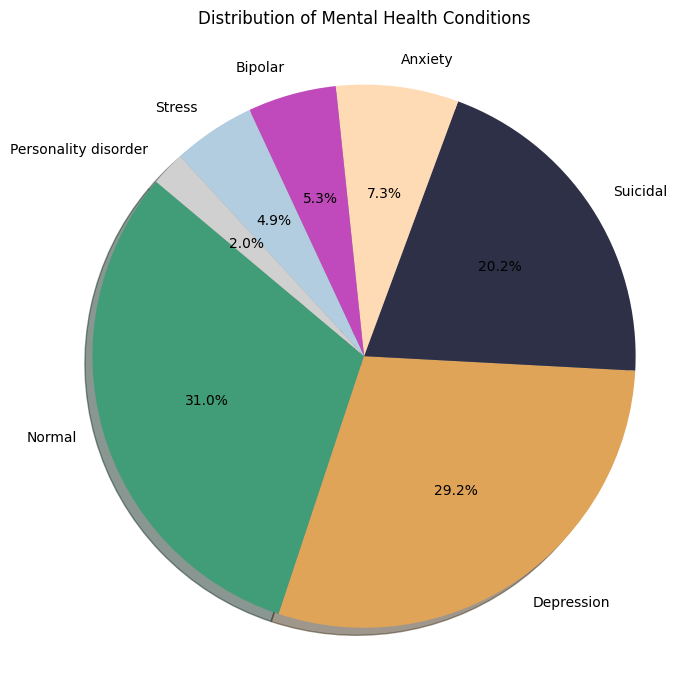

In [10]:
status_counts = df['status'].value_counts()

colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')

plt.tight_layout()
plt.show()

In [11]:
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Scarlet Fever Hey guys, I’m a 20 year old male. I had a bit of a sore throat waking up on Sunday but nothing too serious thought not too much of it, as I was settling down for bed I noticed a bit of a rash on my chest which sent me to immediate panic. Fast forward to Monday and I have a full body rash and getting a lot of chills in the nights and when I wasn’t medicated in the day, I was pretty worried something was seriously wrong with me so organised an appointment with the doctor today. I went in and the doctor did a few tests on me (Checked my throat / tongue, Ears, chest, back and my blood pressure) and then told me “I’m sorry to tell you this but I’m afraid you have scarlet fever” I had no idea what it was until looking online after but surprised a 20 year old like myself has got it as it’s usually only children who get it to my understanding. I asked the doctor again and she confidently said that it was scarlet fever. I’m on a set of antibiotics for 10

In [12]:
import re

# Calculate the number of characters in each statement
df['num_of_characters'] = df['statement'].str.len()

# Calculate the number of sentences using regex
df['num_of_sentences'] = df['statement'].apply(lambda x: len(re.split(r'[.!?]', str(x).strip())) - 1)

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()
print(description)


       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.743152
std           846.269078         12.376316
min             2.000000          0.000000
25%            80.000000          0.000000
50%           317.000000          3.000000
75%           752.000000          9.000000
max         32759.000000       1260.000000


In [13]:
df[df['num_of_characters'] > 10000]


,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,155
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,0
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,201
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,244
11537,"The title is not meant to discourage others, b...",Depression,12304,183
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,106
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,176
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,204


In [14]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)  

df['statement']=df['original_statement'].str.lower()
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,0,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,1,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,1,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,0,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


In [15]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,0,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,1,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,1,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,0,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


In [16]:
df['tokens'] = df['statement'].apply(lambda x: str(x).split())
df.head()


,original_statement,status,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,10,0,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,1,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,1,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,0,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


In [17]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,0,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,1,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,1,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,0,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


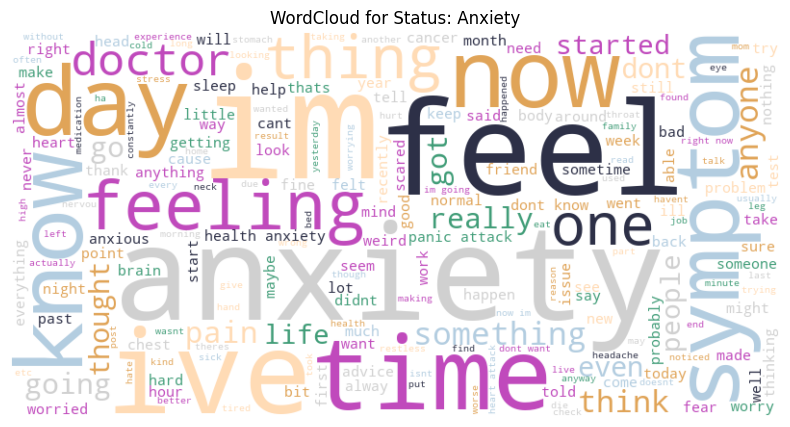

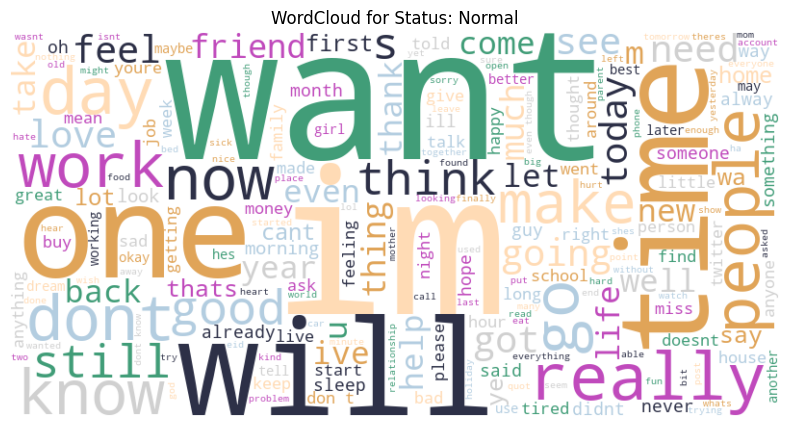

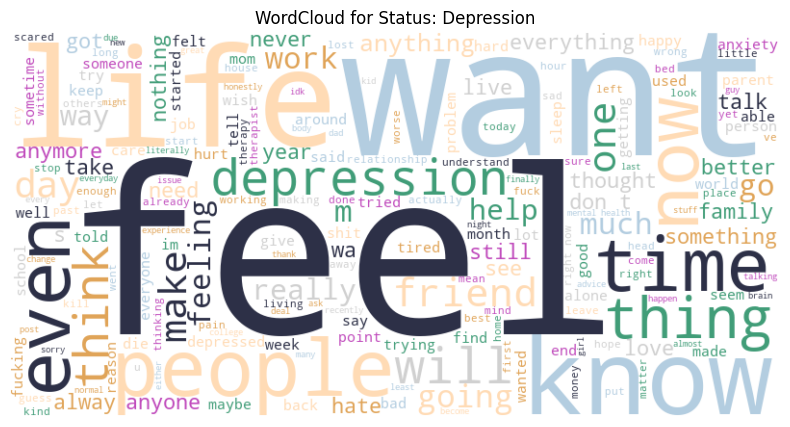

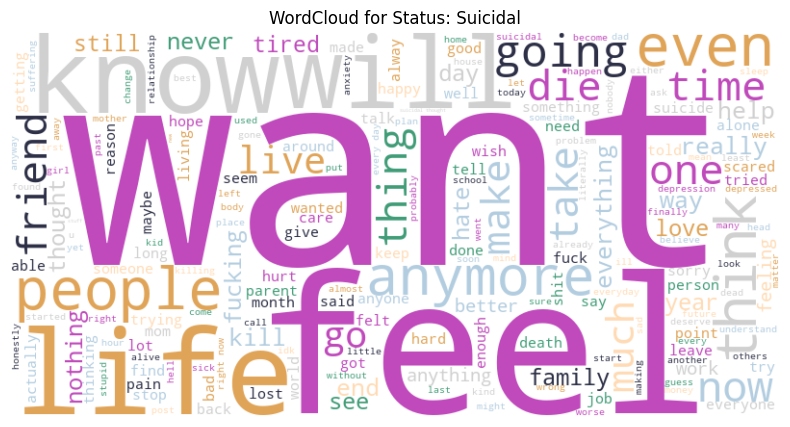

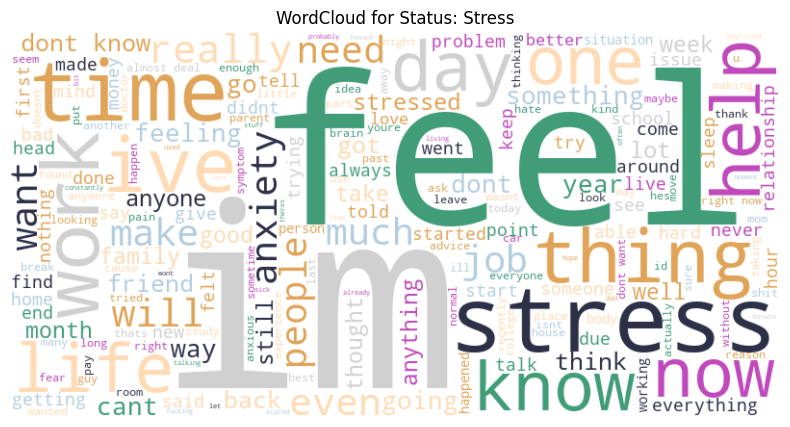

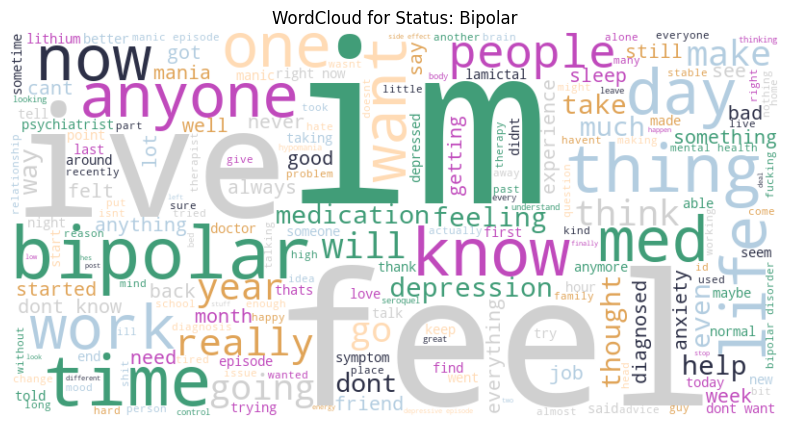

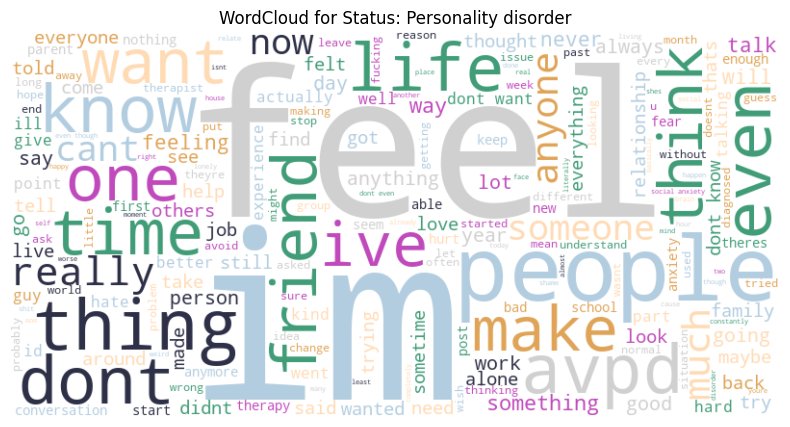

In [18]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

In [19]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [20]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [22]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [23]:
X_train_combined.shape


(42144, 50002)

In [24]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)


In [25]:
X_train_resampled.shape


(91742, 50002)

In [26]:
# Define a dictionary of classifiers with their specific parameters.
# Note: The hyperparameters for these classifiers were chosen after performing GridSearchCV to optimize performance.
classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101), 
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='auto')
}



For Bernoulli Naive Bayes
Accuracy: 0.6424029609945905
                      precision    recall  f1-score   support

             Anxiety       0.67      0.60      0.63       768
             Bipolar       0.70      0.59      0.64       566
          Depression       0.66      0.48      0.56      3050
              Normal       0.67      0.93      0.78      3237
Personality disorder       0.88      0.35      0.50       202
              Stress       0.42      0.52      0.46       530
            Suicidal       0.60      0.54      0.57      2184

            accuracy                           0.64     10537
           macro avg       0.66      0.57      0.59     10537
        weighted avg       0.65      0.64      0.63     10537



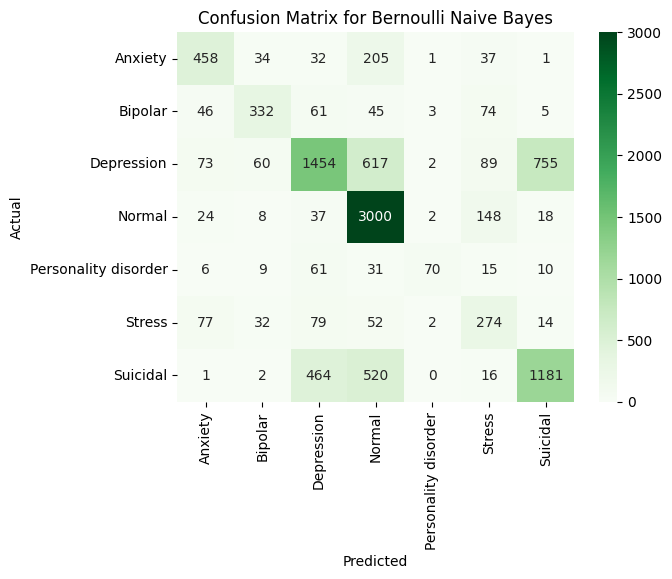



For Decision Tree
Accuracy: 0.621903767675809
                      precision    recall  f1-score   support

             Anxiety       0.62      0.58      0.60       768
             Bipolar       0.43      0.65      0.52       566
          Depression       0.85      0.36      0.50      3050
              Normal       0.86      0.86      0.86      3237
Personality disorder       0.42      0.51      0.46       202
              Stress       0.21      0.45      0.29       530
            Suicidal       0.50      0.69      0.58      2184

            accuracy                           0.62     10537
           macro avg       0.55      0.59      0.54     10537
        weighted avg       0.70      0.62      0.62     10537



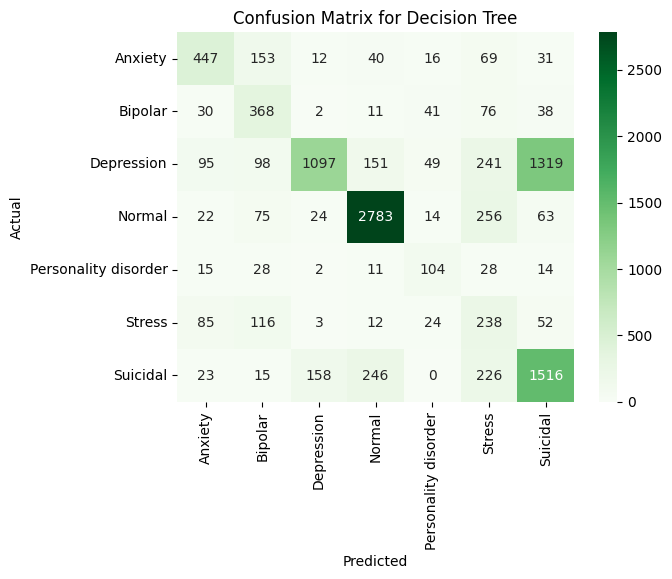



For Logistic Regression
Accuracy: 0.7652083135617348
                      precision    recall  f1-score   support

             Anxiety       0.79      0.81      0.80       768
             Bipolar       0.84      0.80      0.82       566
          Depression       0.72      0.68      0.70      3050
              Normal       0.90      0.92      0.91      3237
Personality disorder       0.72      0.64      0.68       202
              Stress       0.60      0.65      0.62       530
            Suicidal       0.65      0.67      0.66      2184

            accuracy                           0.77     10537
           macro avg       0.74      0.74      0.74     10537
        weighted avg       0.76      0.77      0.76     10537



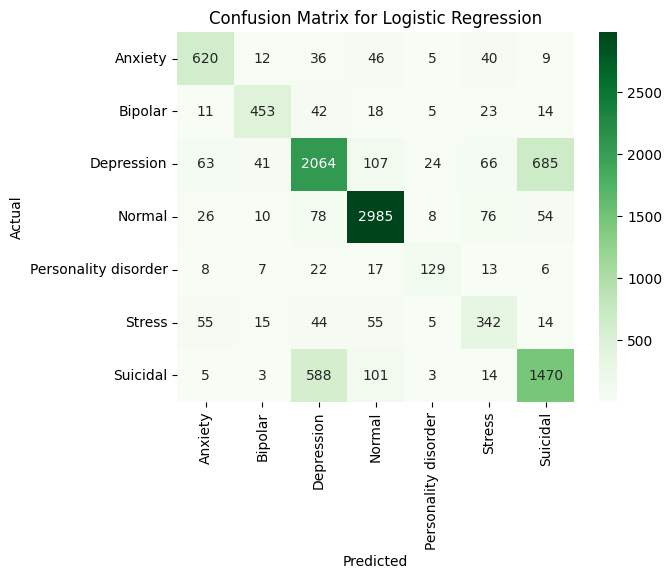



For XGB
Accuracy: 0.7918762456107051
                      precision    recall  f1-score   support

             Anxiety       0.81      0.85      0.83       768
             Bipolar       0.83      0.83      0.83       566
          Depression       0.81      0.67      0.73      3050
              Normal       0.92      0.91      0.92      3237
Personality disorder       0.65      0.74      0.69       202
              Stress       0.57      0.79      0.66       530
            Suicidal       0.67      0.75      0.71      2184

            accuracy                           0.79     10537
           macro avg       0.75      0.79      0.77     10537
        weighted avg       0.80      0.79      0.79     10537



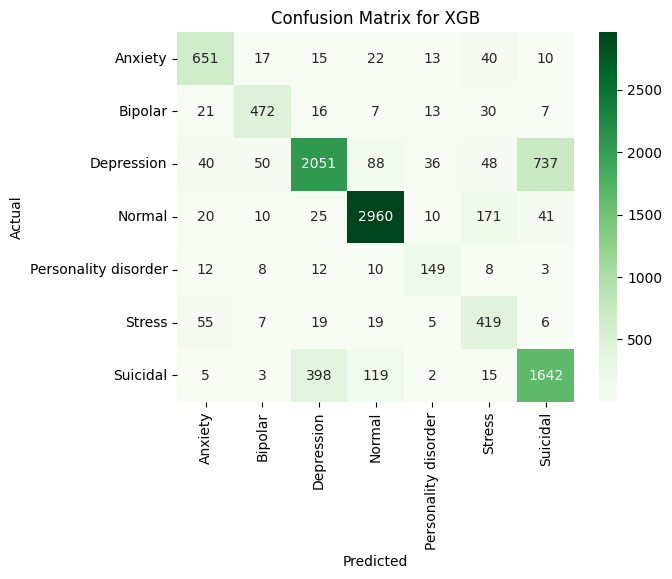

In [27]:
# Initialize a list to store accuracy scores for each classifier
accuracy_scores = []

# Iterate over each classifier and its name in the classifiers dictionary
for name, clf in classifiers.items():
    # Check if the classifier is XGBClassifier and set to use CPU
    if isinstance(clf, XGBClassifier):
        clf = XGBClassifier(tree_method='auto')  # Use CPU

    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)
    
    # Compute the confusion matrix for the predictions
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))
    
    # Plot the confusion matrix using a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')  # Label for x-axis
    plt.ylabel('Actual')     # Label for y-axis
    plt.title(f'Confusion Matrix for {name}')  # Title for the heatmap
    plt.show()  # Display the heatmap
    
    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)

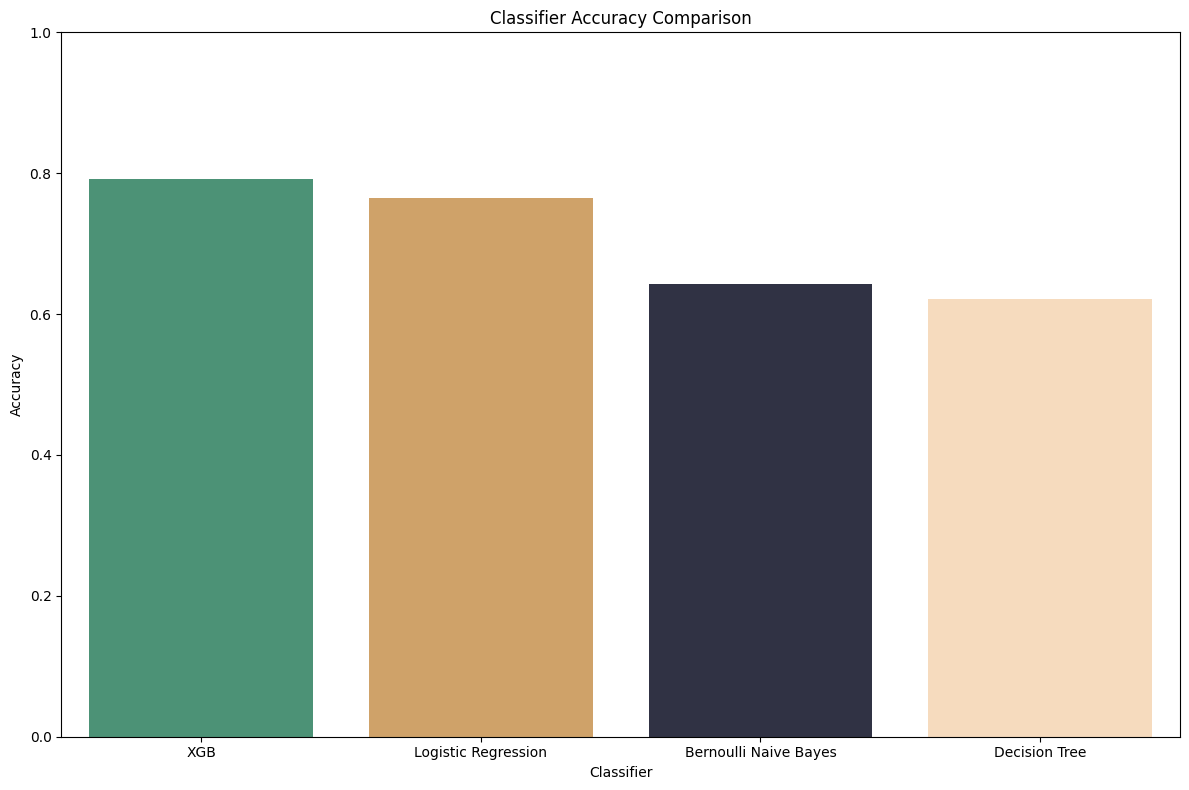

In [28]:
# Create a DataFrame to store classifier names and their corresponding accuracy scores
accuracies_df = pd.DataFrame({'Classifier': classifiers.keys(), 'Accuracy': accuracy_scores}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(12, 8))
palette = dict(zip(accuracies_df['Classifier'], colors[:4]))

# Create a bar plot to visualize the accuracy of each classifier
sns.barplot(x='Classifier', y='Accuracy', data=accuracies_df, palette=palette)

plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()